In [1]:
# Packages

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error as mse

In [ ]:
# Choose line here
# Options: '21', '22', '34', '47', '54', '60', '62', '63', '77', '79', '97', '94', '146', '152'

line = '21'

In [3]:
# Import data
df = pd.read_csv('../Data/CTA_Average_Bus_Ridership_1999_2024_cleaned.csv')

# Sort by date
df['DATE'] = pd.to_datetime(df['DATE'])
df.sort_values('DATE', inplace=True)

# Consider ridership averages in thousands
df = df.rename(columns={'Sunday - Holiday': 'SundayHoliday'})
df['Weekday'] = df['Weekday'].div(1000)
df['Saturday'] = df['Saturday'].div(1000)
df['SundayHoliday'] = df['SundayHoliday'].div(1000)

# Show first 5 rows
df.head()

,BUS,YEAR,MONTH,Weekday,Saturday,SundayHoliday,Sum,DATE
0,103,1999,1,3.640,1.337,0.944,5921,1999-01-01
18038,8,1999,1,17.505,10.464,7.264,35233,1999-01-01
17727,79,1999,1,27.251,19.609,13.719,60579,1999-01-01
17416,78,1999,1,7.985,4.004,2.808,14797,1999-01-01
2177,146,1999,1,8.266,4.088,2.938,15292,1999-01-01


In [4]:
"""
This function takes in a single bus route as a string, retricts the bus
dataframe to this one route. If only the bus route is given, the function
will plot the Weekday, Saturday, and Sunday-Holiday ridership averages
and return the restricted dataframe. If a second False argument is given,
the function will just return the restricted dataframe.
"""

def plot_bus_routes(bus_route, plot=True, save = True):
    # Restrict dataframe to bus route
    bus_route_df = df[df['BUS'] == bus_route]

    # Plot!
    if plot:
        # Create plot
        plt.figure(figsize=(20,8))

        # Plot all day types
        plt.plot(bus_route_df.DATE, bus_route_df.Weekday, 'r', label='Weekday Average')
        plt.plot(bus_route_df.DATE, bus_route_df.Saturday, 'g', label='Saturday Average')
        plt.plot(bus_route_df.DATE, bus_route_df.SundayHoliday, 'b', label='Sunday/Holiday Average')

        # Aesthetics
        plt.title(bus_route + " Bus Ridership", fontsize=24)
        plt.xlabel("Date", fontsize=18)
        plt.ylabel("Ridership on Day Type by Month in Thousands", fontsize=18)

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        plt.legend(fontsize=14, loc=3)

        # Save!
        if save:
            plt.savefig(bus_route+"bus.png")

        # Show!
        plt.show()

    # Return dataframe
    return bus_route_df

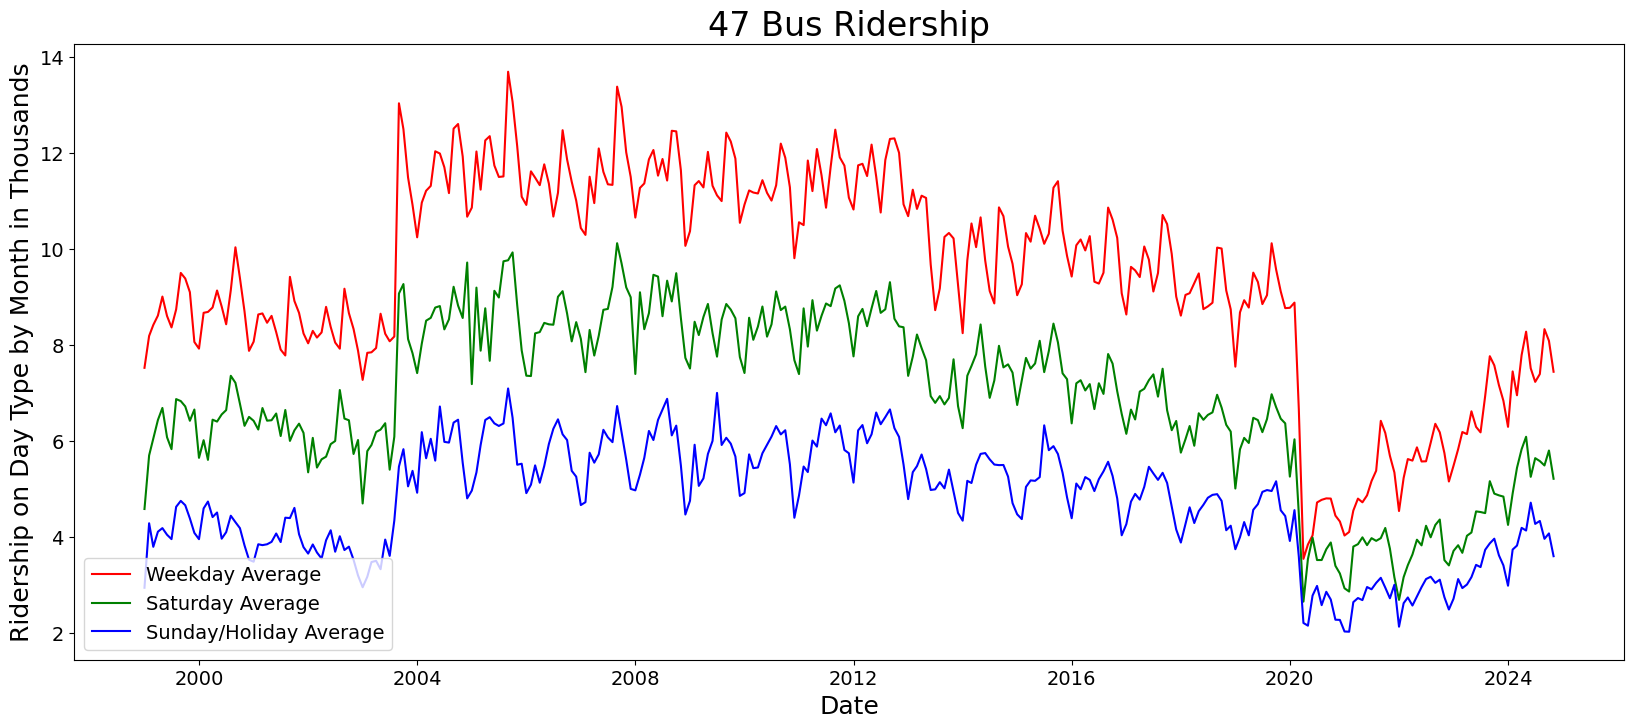

In [5]:
# Plot all data for chosen line

df_line = plot_bus_routes(line, plot=True, save=False)

In [6]:
# Make traing and test sets
# Only start training 4 months after start of COVID impact

df_line_train = df_line.drop(df_line.tail(12).index, inplace=False)[-40:]
df_line_test = df_line.tail(12)

In [7]:
# Create Triple Exponential Smoothing Models for each Day Type
# (This section of code may take a couple minutes to run)

# New test/train sets
df_line_train_train = df_line_train.drop(df_line_train.tail(12).index)
df_line_train_test = df_line_train.tail(12)

### Weekday

## Check for parameters (i,j,k) that minimize mean squared error (mse)

# Set parameters and mse to default values (will always be overwritten)
best_ijk = [1,0,0]
best_err = 10000000

# Train models with parameters checked in increments of .01
# Note that we multiply parameters by 100 since it is easier if they are integers
for i in range(0,101,1):
    for j in range(0,101-i,1):
        # Parameters must add to 1
        k=100-i-j

        # Create model

        # The trend appears linear, so we set trend='add' instead of 'mul'
        # It is intuitive that ridership changes by percentages month-to-month rather than
        #       by flat numbers, so we set seasonal='mul' in contrast
        # There are 12 months in a year, so seasonal_periods=12
        es = ExponentialSmoothing(df_line_train.Weekday.values,
                                      trend='add',
                                      seasonal='mul',
                                      seasonal_periods=12).fit(smoothing_level=i/100,
                                                                  smoothing_trend=j/100,
                                                                  smoothing_seasonal=k/100,
                                                                  optimized=False)
        
        # Make predictions, then find mse to test set
        es_preds = es.forecast(12)
        err = mse(df_line_train_test.Weekday.values, es_preds)

        # Check if this model has least error yet
        if err < best_err:
            best_ijk = [i/100,j/100,k/100]
            best_err = err

## Make model with best parameters
es3_weekday = ExponentialSmoothing(df_line_train.Weekday.values,
                                      trend='add',
                                      seasonal='mul',
                                      seasonal_periods=12).fit(smoothing_level=best_ijk[0],
                                                                  smoothing_trend=best_ijk[1],
                                                                  smoothing_seasonal=best_ijk[2],
                                                                  optimized=False)

### Saturday

## Check for parameters (i,j,k) that minimize mean squared error (mse)

# Set parameters and mse to default values (will always be overwritten)
best_ijk = [1,0,0]
best_err = 10000000

# Train models with parameters checked in increments of .05
# Note that we multiply parameters by 100 since it is easier if they are type int
for i in range(0,101,1):
    for j in range(0,101-i,1):
        # Parameters must add to 1
        k=100-i-j

        # Create model

        # The trend appears linear, so we set trend='add' instead of 'mul'
        # It is intuitive that ridership changes by percentages month-to-month rather than
        #       by flat numbers, so we set seasonal='mul' in contrast
        # There are 12 months in a year, so seasonal_periods=12
        es = ExponentialSmoothing(df_line_train.Saturday.values,
                                      trend='add',
                                      seasonal='mul',
                                      seasonal_periods=12).fit(smoothing_level=i/100,
                                                                  smoothing_trend=j/100,
                                                                  smoothing_seasonal=k/100,
                                                                  optimized=False)
        
        # Make predictions, then find mse to test set
        es_preds = es.forecast(12)
        err = mse(df_line_train_test.Saturday.values, es_preds)

        # Check if this model has least error yet
        if err < best_err:
            best_ijk = [i/100,j/100,k/100]
            best_err = err

## Make model with best parameters
es3_saturday = ExponentialSmoothing(df_line_train.Saturday.values,
                                      trend='add',
                                      seasonal='mul',
                                      seasonal_periods=12).fit(smoothing_level=best_ijk[0],
                                                                  smoothing_trend=best_ijk[1],
                                                                  smoothing_seasonal=best_ijk[2],
                                                                  optimized=False)

### Sunday/Holiday

## Check for parameters (i,j,k) that minimize mean squared error (mse)

# Set parameters and mse to default values (will always be overwritten)
best_ijk = [1,0,0]
best_err = 10000000

# Train models with parameters checked in increments of .05
# Note that we multiply parameters by 100 since it is easier if they are type int
for i in range(0,101,1):
    for j in range(0,101-i,1):
        # Parameters must add to 1
        k=100-i-j

        # Create model

        # The trend appears linear, so we set trend='add' instead of 'mul'
        # It is intuitive that ridership changes by percentages month-to-month rather than
        #       by flat numbers, so we set seasonal='mul' in contrast
        # There are 12 months in a year, so seasonal_periods=12
        es = ExponentialSmoothing(df_line_train.SundayHoliday.values,
                                      trend='add',
                                      seasonal='mul',
                                      seasonal_periods=12).fit(smoothing_level=i/100,
                                                                  smoothing_trend=j/100,
                                                                  smoothing_seasonal=k/100,
                                                                  optimized=False)
        
        # Make predictions, then find mse to test set
        es_preds = es.forecast(12)
        err = mse(df_line_train_test.SundayHoliday.values, es_preds)

        # Check if this model has least error yet
        if err < best_err:
            best_ijk = [i/100,j/100,k/100]
            best_err = err

## Make model with best parameters
es3_sundayholiday = ExponentialSmoothing(df_line_train.SundayHoliday.values,
                                      trend='add',
                                      seasonal='mul',
                                      seasonal_periods=12).fit(smoothing_level=best_ijk[0],
                                                                  smoothing_trend=best_ijk[1],
                                                                  smoothing_seasonal=best_ijk[2],
                                                                  optimized=False)

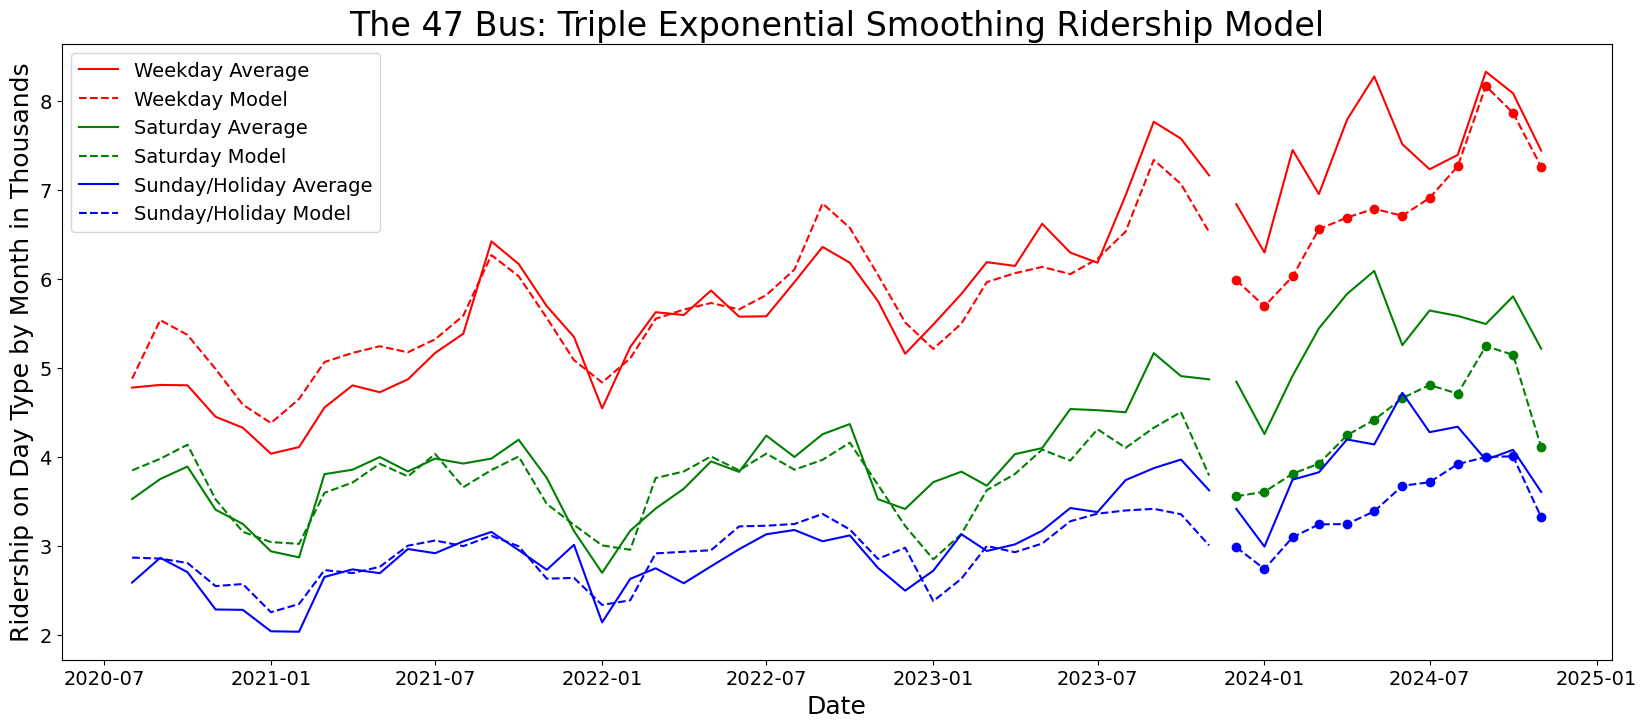

In [8]:
# Make plot
plt.figure(figsize=(20,8))

# Weekday
plt.plot(df_line_train.DATE, df_line_train.Weekday, 'r', label="Weekday Average")
plt.plot(df_line_train.DATE, es3_weekday.fittedvalues, 'r--', label="Weekday Model")
plt.plot(df_line_test.DATE, df_line_test.Weekday, 'r')
plt.plot(df_line_test.DATE, es3_weekday.forecast(12), 'r--o')

# Saturday
plt.plot(df_line_train.DATE, df_line_train.Saturday, 'g', label="Saturday Average")
plt.plot(df_line_train.DATE, es3_saturday.fittedvalues, 'g--', label="Saturday Model")
plt.plot(df_line_test.DATE, df_line_test.Saturday, 'g')
plt.plot(df_line_test.DATE, es3_saturday.forecast(12), 'g--o')

# Sunday - Holiday
plt.plot(df_line_train.DATE, df_line_train.SundayHoliday, 'b', label="Sunday/Holiday Average")
plt.plot(df_line_train.DATE, es3_sundayholiday.fittedvalues, 'b--', label="Sunday/Holiday Model")
plt.plot(df_line_test.DATE, df_line_test.SundayHoliday, 'b')
plt.plot(df_line_test.DATE, es3_sundayholiday.forecast(12), 'b--o')

# Aesthetics
plt.title("The "+line+" Bus: Triple Exponential Smoothing Ridership Model", fontsize=24)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Ridership on Day Type by Month in Thousands", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=2)

# Save!
plt.savefig("es3_"+line+".png")

# Show!
plt.show()